<a href="https://www.kaggle.com/code/les1781/rainfall-prediction-playground-series-s5-e3?scriptVersionId=230835961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score, 
    roc_curve, 
    roc_auc_score
)

# Binary Prediction with a Rainfall Dataset

### Playground Series - Season 5, Episode 3

### Your Goal:

Your goal is to predict rainfall for each day of the year.

### Evaluation:

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Submission File:

For each id in the test set, you must predict a probability for the target rainfall. The file should contain a header and have the following format:

id,rainfall

2190,0.5
2191,0.1
2192,0.9
etc.

### Timeline:

Start Date - March 1, 2025
Entry Deadline - Same as the Final Submission Deadline
Team Merger Deadline - Same as the Final Submission Deadline
Final Submission Deadline - March 31, 2025
All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

In [3]:
# We load the data

rainfall_train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv", index_col="id")

In [4]:
rainfall_train.shape

(2190, 12)

In [5]:
rainfall_train.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [6]:
rainfall_train.describe().style.background_gradient(cmap='Greens')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [7]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


# EDA

In [8]:
# Function to view the data of each variable in detail

def detail_columns(data, colum):

    print(
        "Variable: ", colum,
        "\nFormat: ", data[colum].dtype,
        "\nNumber of null values: ", data[colum].isnull().sum(),
        "\nUnique values: ", data[colum].nunique(),
        "\nDistribution of values: \n", data[colum].value_counts()
    )

## Rainfall (Target variable)

In [9]:
detail_columns(rainfall_train, "rainfall")

Variable:  rainfall 
Format:  int64 
Number of null values:  0 
Unique values:  2 
Distribution of values: 
 rainfall
1    1650
0     540
Name: count, dtype: int64


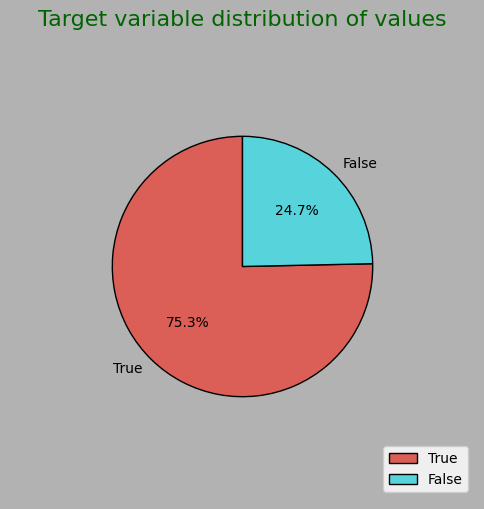

In [10]:
fig,ax = plt.subplots(figsize =(6, 8))
fig.set_facecolor("#b2b2b2")
rainfall_values = ["True", "False"]

ax.pie(
    rainfall_train["rainfall"].value_counts(),
    labels=rainfall_values,
    radius=0.7, 
    startangle=90, 
    autopct= '%1.1f%%',
    colors=sns.color_palette('hls',2),
    wedgeprops={'edgecolor' : 'k'}
)

plt.title("Target variable distribution of values", color='darkgreen', fontsize=16)
plt.legend(loc='lower right', labels=rainfall_values, fontsize=10)

# Mostrar los gráficos

plt.show()

We found unbalanced classes, and there is no missing data. Most samples fall into class 1.

## Day & Pressure

In [11]:
detail_columns(rainfall_train, "day")
print("-" * 50)
detail_columns(rainfall_train, "pressure")

Variable:  day 
Format:  int64 
Number of null values:  0 
Unique values:  365 
Distribution of values: 
 day
91     7
144    7
267    7
140    7
111    7
      ..
157    5
286    5
38     5
336    5
365    5
Name: count, Length: 365, dtype: int64
--------------------------------------------------
Variable:  pressure 
Format:  float64 
Number of null values:  0 
Unique values:  236 
Distribution of values: 
 pressure
1008.1    64
1008.5    48
1008.4    48
1016.8    46
1008.9    42
          ..
1007.0     1
1026.5     1
1020.7     1
1004.5     1
1011.8     1
Name: count, Length: 236, dtype: int64


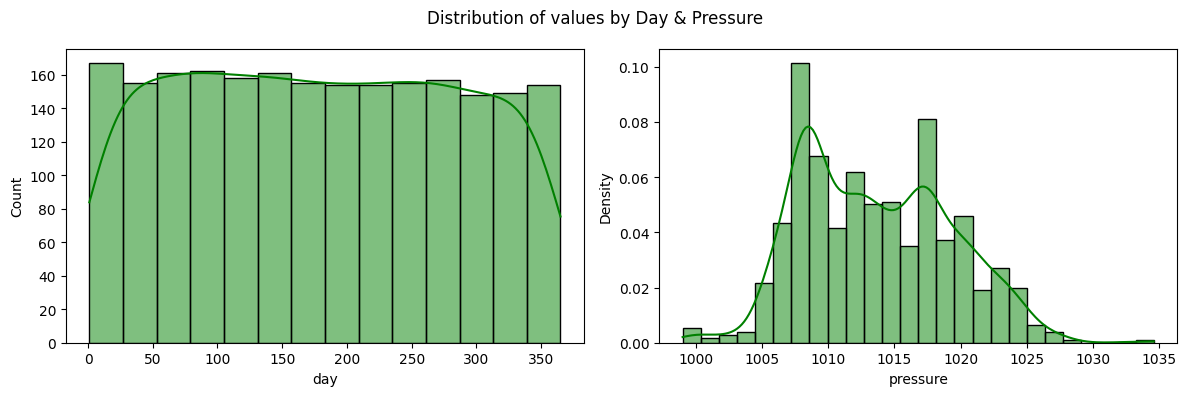

In [12]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(
    data=rainfall_train, 
    x="day", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=rainfall_train, 
    x="pressure",
    color="green",
    edgecolor="k",
    kde=True,
    stat="density",
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Day & Pressure")
plt.tight_layout()
plt.show()

We see that the number of unique values for the variable "Day" is correct, we should analyze the number of years it represents, and make sure that there are no mislabeled values, the number of duplicate values should be the same. We did not find null data.

In [13]:
print("Total days: ", rainfall_train["day"].value_counts().sum(),
      "\nTotal years: 6 (", rainfall_train["day"].value_counts().sum() ,"/ 6 = 365",
      "\nTotal correct values(==6): ", (rainfall_train["day"].value_counts() == 6).sum(),
      "\nTotal erroneous values(> 6): ", (rainfall_train["day"].value_counts() > 6).sum(),
      "\nTotal erroneous values(< 6): ", (rainfall_train["day"].value_counts() < 6).sum()
     )

Total days:  2190 
Total years: 6 ( 2190 / 6 = 365 
Total correct values(==6):  297 
Total erroneous values(> 6):  34 
Total erroneous values(< 6):  34


We found 68 incorrect values in the variable "day", Considering that the dataset records 6 years, no value count should be greater than 6. It is logical to say that the missing values (<6) are the ones we found exceeded.

## Temparature, Mintemp & Maxtemp

In [14]:
detail_columns(rainfall_train, "temparature")
print("-" * 50)
detail_columns(rainfall_train, "mintemp")
print("-" * 50)
detail_columns(rainfall_train, "maxtemp")

Variable:  temparature 
Format:  float64 
Number of null values:  0 
Unique values:  198 
Distribution of values: 
 temparature
30.1    55
28.1    49
30.0    48
25.8    44
25.5    38
        ..
12.6     1
14.1     1
13.9     1
17.0     1
8.7      1
Name: count, Length: 198, dtype: int64
--------------------------------------------------
Variable:  mintemp 
Format:  float64 
Number of null values:  0 
Unique values:  199 
Distribution of values: 
 mintemp
26.8    52
24.8    51
26.4    48
28.1    42
26.9    42
        ..
4.0      1
12.2     1
10.5     1
13.2     1
12.5     1
Name: count, Length: 199, dtype: int64
--------------------------------------------------
Variable:  maxtemp 
Format:  float64 
Number of null values:  0 
Unique values:  219 
Distribution of values: 
 maxtemp
31.0    43
21.3    42
31.2    40
32.0    37
33.0    37
        ..
25.7     1
13.5     1
15.7     1
11.3     1
24.1     1
Name: count, Length: 219, dtype: int64


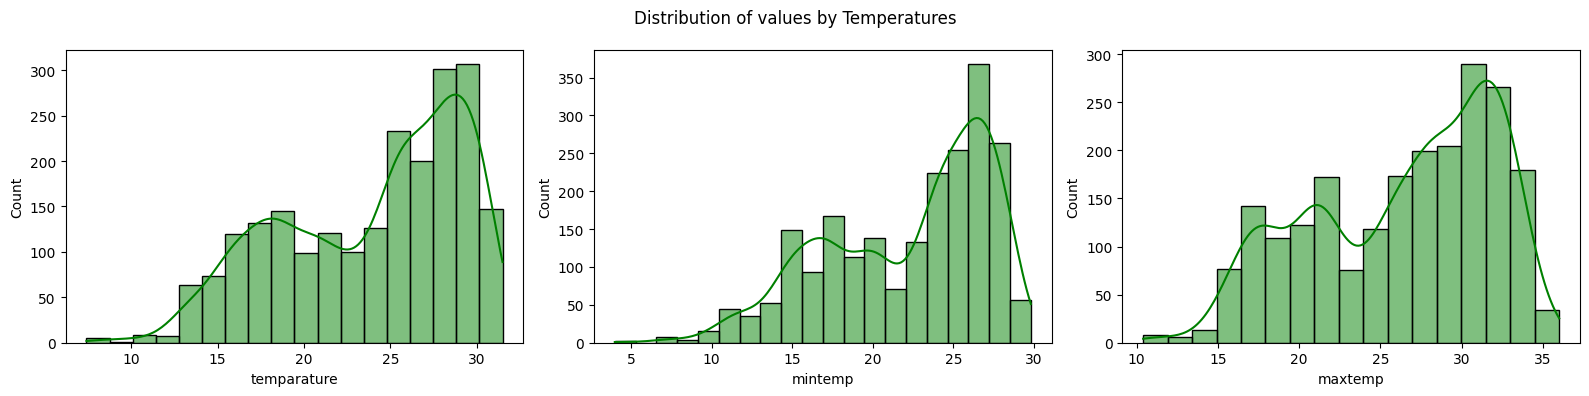

In [15]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

sns.histplot(
    data=rainfall_train, 
    x="temparature", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=rainfall_train, 
    x="mintemp",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
)

sns.histplot(
    data=rainfall_train, 
    x="maxtemp",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[2]
)

plt.suptitle(t="Distribution of values by Temperatures")
plt.tight_layout()
plt.show()

No variable presents null data. We find the general temperature range, as well as its maximums and minimums. We found a greater number of temperature values greater than 25. The name of the temperature column is written incorrectly, it would be interesting to see if the error persists in the test data. Having the general temperature variable, we could get rid of 'min and max temp', but we will analyze the correlation and importance of these variables later.

## Dewpoint & Humidity

In [16]:
detail_columns(rainfall_train, "dewpoint")
print("-" * 50)
detail_columns(rainfall_train, "humidity")

Variable:  dewpoint 
Format:  float64 
Number of null values:  0 
Unique values:  218 
Distribution of values: 
 dewpoint
25.4    70
25.3    66
25.0    56
25.8    54
24.3    46
        ..
7.8      1
10.3     1
10.4     1
1.0      1
8.8      1
Name: count, Length: 218, dtype: int64
--------------------------------------------------
Variable:  humidity 
Format:  float64 
Number of null values:  0 
Unique values:  49 
Distribution of values: 
 humidity
79.0    192
81.0    139
75.0    133
78.0    121
84.0    119
89.0    114
82.0    108
87.0    106
86.0    102
76.0     89
77.0     88
90.0     81
85.0     72
91.0     71
74.0     68
92.0     66
93.0     59
80.0     55
95.0     55
72.0     47
83.0     45
70.0     37
88.0     30
94.0     22
73.0     22
96.0     20
97.0     20
98.0     14
67.0     12
65.0     10
59.0      9
71.0      9
62.0      9
69.0      7
61.0      6
58.0      5
68.0      5
64.0      5
52.0      4
63.0      3
46.0      2
60.0      2
39.0      1
66.0      1
56.0      1
54.0  

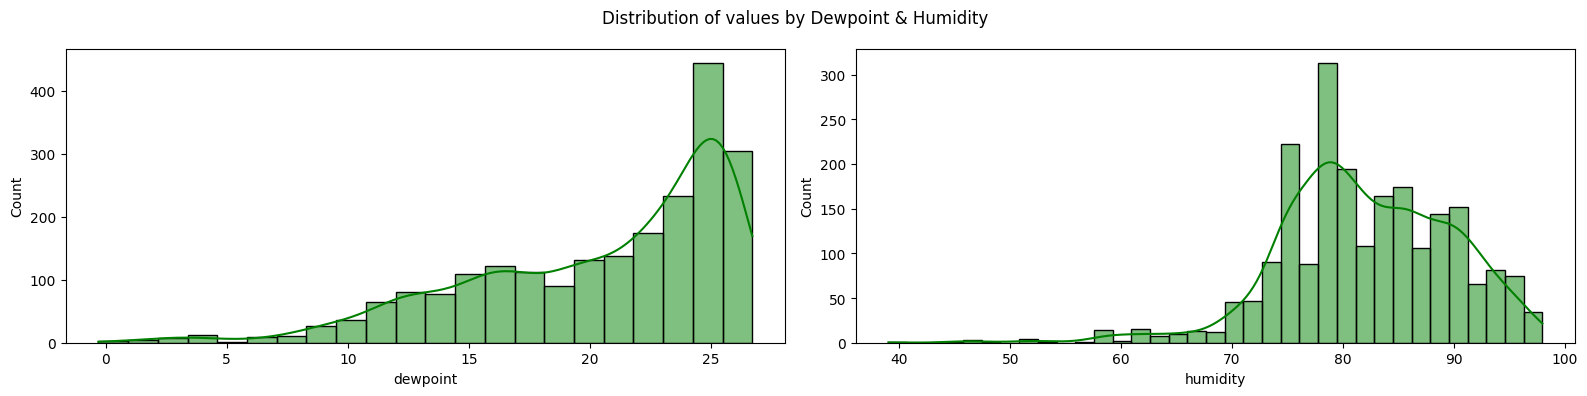

In [17]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

sns.histplot(
    data=rainfall_train, 
    x="dewpoint", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=rainfall_train, 
    x="humidity",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Dewpoint & Humidity")
plt.tight_layout()
plt.show()

Both variables do not present null data. There is a clear and logical positive correlation, since the dew point is an important indicator of air humidity. Both variables have a distribution skewed to the right.

## Cloud & Sunshine

In [18]:
detail_columns(rainfall_train, "cloud")
print("-" * 50)
detail_columns(rainfall_train, "sunshine")

Variable:  cloud 
Format:  float64 
Number of null values:  0 
Unique values:  78 
Distribution of values: 
 cloud
88.0    375
84.0    129
83.0    127
78.0     95
81.0     88
       ... 
33.0      2
34.0      2
7.0       1
27.0      1
2.0       1
Name: count, Length: 78, dtype: int64
--------------------------------------------------
Variable:  sunshine 
Format:  float64 
Number of null values:  0 
Unique values:  120 
Distribution of values: 
 sunshine
0.0     337
0.1      69
0.3      63
0.2      58
0.6      55
       ... 
8.9       2
12.1      1
4.0       1
12.0      1
11.7      1
Name: count, Length: 120, dtype: int64


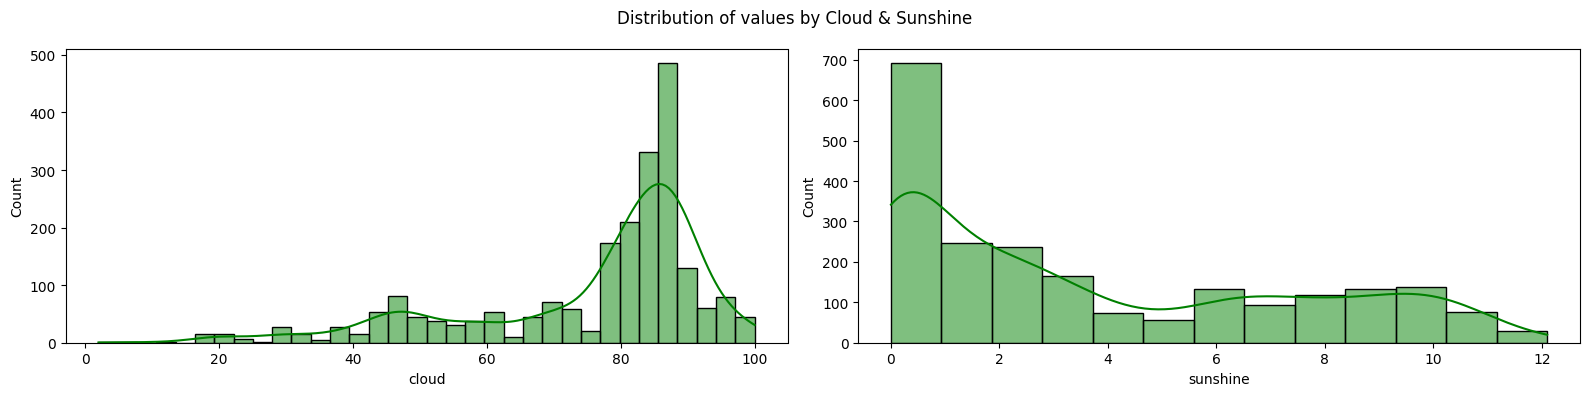

In [19]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

sns.histplot(
    data=rainfall_train, 
    x="cloud", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=rainfall_train, 
    x="sunshine",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Cloud & Sunshine")
plt.tight_layout()
plt.show()

The variables do not present null data. We find a logical relationship in that if one increases the other decreases. In the case of a clear sky it is a distribution skewed to the left, with a bias towards the right for a cloudy sky.

## Winddirection & Windspeed

In [20]:
detail_columns(rainfall_train, "winddirection")
print("-" * 50)
detail_columns(rainfall_train, "windspeed")

Variable:  winddirection 
Format:  float64 
Number of null values:  0 
Unique values:  35 
Distribution of values: 
 winddirection
70.0     273
220.0    241
20.0     238
40.0     230
50.0     199
80.0     178
60.0     152
230.0    142
30.0      70
200.0     58
190.0     50
10.0      47
240.0     43
100.0     33
180.0     31
210.0     30
90.0      28
130.0     27
110.0     20
120.0     15
170.0     14
270.0     10
290.0     10
280.0      9
250.0      9
300.0      7
140.0      7
160.0      6
150.0      4
25.0       3
260.0      2
75.0       1
15.0       1
250.3      1
65.0       1
Name: count, dtype: int64
--------------------------------------------------
Variable:  windspeed 
Format:  float64 
Number of null values:  0 
Unique values:  223 
Distribution of values: 
 windspeed
14.5    35
21.9    33
25.1    32
20.5    32
25.0    31
        ..
29.3     2
24.3     2
5.7      2
5.9      2
4.4      1
Name: count, Length: 223, dtype: int64


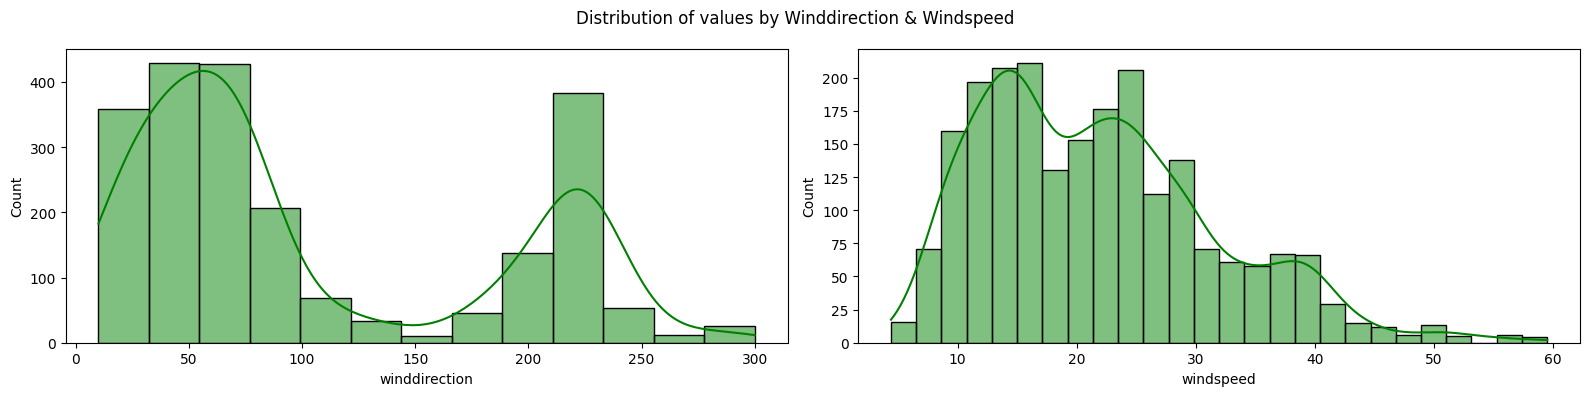

In [21]:
# We analyze the distribution of the data

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

sns.histplot(
    data=rainfall_train, 
    x="winddirection", 
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[0]
)

sns.histplot(
    data=rainfall_train, 
    x="windspeed",
    color="green",
    edgecolor="k",
    kde=True,
    ax=axes[1]
)

plt.suptitle(t="Distribution of values by Winddirection & Windspeed")
plt.tight_layout()
plt.show()

We did not find null data present as in the rest of the columns. For wind speed, we see a distribution skewed to the right, the mode is greater than the median, and this in turn is greater than the mean. We found a more dispersed distribution of values for wind direction.

# Data wrangling

In [22]:
# We make a copy of the original dataset

rainfall_new = rainfall_train.copy()

In [23]:
# We check that no duplicate data is found

print(f"Length: {len(rainfall_new.duplicated())}")
print(f"Duplicates: {rainfall_new.duplicated().sum()}")

Length: 2190
Duplicates: 0


In [24]:
# We check for null values

null_values = (
    pd.DataFrame(
        {f"Amount of Null Data": rainfall_new.isnull().sum(), 
         "Percentage of Null Data" : (
             rainfall_new.isnull().sum()) / (len(rainfall_new)) * (100)
        }))

null_values.style.background_gradient(cmap="Greens")

,Amount of Null Data,Percentage of Null Data
day,0,0.000000
pressure,0,0.000000
maxtemp,0,0.000000
temparature,0,0.000000
mintemp,0,0.000000
dewpoint,0,0.000000
humidity,0,0.000000
cloud,0,0.000000
sunshine,0,0.000000
winddirection,0,0.000000


### Day

In [25]:
# Column "day" with adjusted values in 365-day cycles

rainfall_new["day"] = (rainfall_new.index % 365) + 1

In [26]:
# We check the variable

print("Total days: ", rainfall_new["day"].value_counts().sum(),
      "\nTotal years: 6 (", rainfall_new["day"].value_counts().sum() ,"/ 6 = 365",
      "\nTotal correct values(==6): ", (rainfall_new["day"].value_counts() == 6).sum(),
      "\nTotal erroneous values(> 6): ", (rainfall_new["day"].value_counts() > 6).sum(),
      "\nTotal erroneous values(< 6): ", (rainfall_new["day"].value_counts() < 6).sum()
     )

Total days:  2190 
Total years: 6 ( 2190 / 6 = 365 
Total correct values(==6):  365 
Total erroneous values(> 6):  0 
Total erroneous values(< 6):  0


In [27]:
# We create a "year" column based on 365-day blocks

start_year = 1981

rainfall_new["year"] = start_year + (rainfall_new.index // 365)

# Convert "year" and "day" to "date_parsed"

rainfall_new["date_parsed"] = pd.to_datetime(
    rainfall_new["year"].astype(str) + "-" + rainfall_new["day"].astype(str), 
    format="%Y-%j"
)

In [28]:
rainfall_new["date_parsed"].head()

id
0   1981-01-01
1   1981-01-02
2   1981-01-03
3   1981-01-04
4   1981-01-05
Name: date_parsed, dtype: datetime64[ns]

In [29]:
# We check all the values in the column

day_data = rainfall_new['date_parsed'].dt.day
month_data = rainfall_new['date_parsed'].dt.month
year_data = rainfall_new['date_parsed'].dt.year

print(
    "Valores únicos de día: ", day_data.unique(),
    "\nValores únicos de mes: ", month_data.unique(),
    "\nValores únicos de year: ", year_data.unique()
)

Valores únicos de día:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 
Valores únicos de mes:  [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Valores únicos de year:  [1981 1982 1983 1984 1985 1986]


In [30]:
rainfall_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   day            2190 non-null   int64         
 1   pressure       2190 non-null   float64       
 2   maxtemp        2190 non-null   float64       
 3   temparature    2190 non-null   float64       
 4   mintemp        2190 non-null   float64       
 5   dewpoint       2190 non-null   float64       
 6   humidity       2190 non-null   float64       
 7   cloud          2190 non-null   float64       
 8   sunshine       2190 non-null   float64       
 9   winddirection  2190 non-null   float64       
 10  windspeed      2190 non-null   float64       
 11  rainfall       2190 non-null   int64         
 12  year           2190 non-null   int64         
 13  date_parsed    2190 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 256.6 KB


# Hipótesis

Below we will develop some questions, not only to pose some hypotheses, but also to analyze the data in greater depth. We will start by taking the most important variables to predict rain such as temperature, atmospheric pressure and humidity.

>- How did rainfall behave per year?

In [31]:
year_rain = rainfall_new.pivot(index="date_parsed", columns="year", values="rainfall")
year_rain.describe()

year,1981,1982,1983,1984,1985,1986
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.728767,0.753425,0.745205,0.750685,0.756164,0.786301
std,0.445206,0.431609,0.436344,0.433210,0.429984,0.410479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


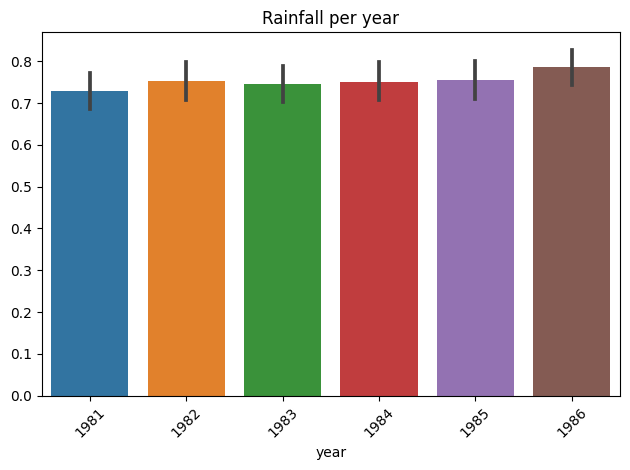

In [32]:
# We graph the rainfall per year

sns.barplot(data=year_rain).tick_params(axis='x', labelrotation=45)

plt.title("Rainfall per year")
plt.tight_layout()
plt.show()

<Axes: xlabel='year', ylabel='day'>

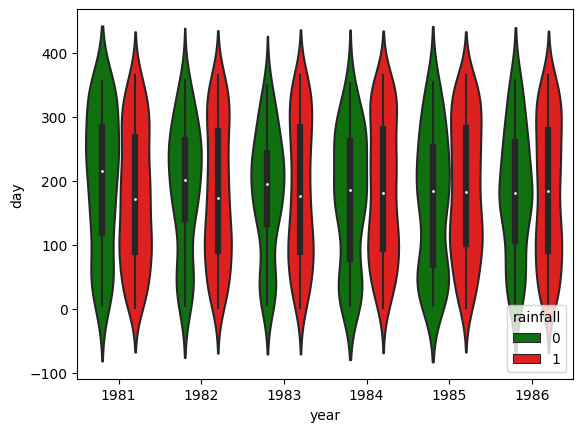

In [33]:
sns.violinplot(
    data=rainfall_new, 
    x="year", 
    y="day", 
    hue="rainfall", 
    palette={0:"green", 1:"red"}
)

We can see that the last year had the highest rainfall. We observed an increase from the previous three years until the most recent. It would be interesting to have more records to see if this is a trend, and every four years there are higher rainfalls. We see an average of around 0.75 for these 6 years, we should analyze the monthly behavior.

>- How did temperature, humidity and atmospheric pressure behave each year?

In [34]:
year_pressure = rainfall_new.pivot(index="date_parsed", columns="year", values="pressure")
year_pressure.describe()

year,1981,1982,1983,1984,1985,1986
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,1013.715068,1013.542740,1013.667123,1013.595342,1013.741918,1013.350685
std,5.419188,5.458267,5.746816,5.794992,5.834359,5.694458
min,1001.000000,1000.200000,999.000000,999.000000,999.000000,999.000000
25%,1008.700000,1008.700000,1008.500000,1008.500000,1008.800000,1008.500000
50%,1013.500000,1012.900000,1013.200000,1013.100000,1013.000000,1013.000000
75%,1017.700000,1017.700000,1018.400000,1017.600000,1017.900000,1017.100000
max,1034.600000,1034.600000,1027.100000,1027.900000,1027.800000,1034.600000


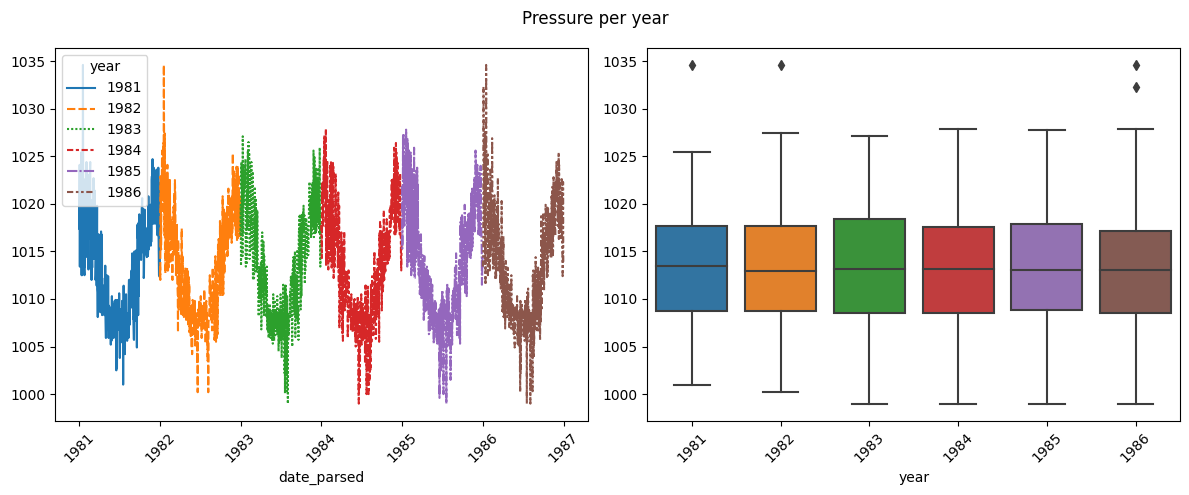

In [35]:
# We graph the pressure per year

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.lineplot(data=year_pressure, ax=axes[0]).tick_params(axis='x', labelrotation=45)
sns.boxplot(data=year_pressure, ax=axes[1]).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Pressure per year")
plt.tight_layout()
plt.show()

We observed lower average pressure in the years with the greatest rainfall, and also found some outliers in three of the years. We see an average pressure of around 1013.0

In [36]:
year_humidity = rainfall_new.pivot(index="date_parsed", columns="year", values="humidity")
year_humidity.describe()

year,1981,1982,1983,1984,1985,1986
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,82.167123,82.564384,81.863014,81.553425,82.134247,81.936986
std,7.131189,7.557424,8.028991,7.974239,7.966348,8.116181
min,52.000000,47.000000,49.000000,39.000000,58.000000,45.000000
25%,78.000000,78.000000,76.000000,76.000000,77.000000,78.000000
50%,82.000000,82.000000,81.000000,81.000000,82.000000,81.000000
75%,87.000000,89.000000,88.000000,87.000000,88.000000,88.000000
max,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000


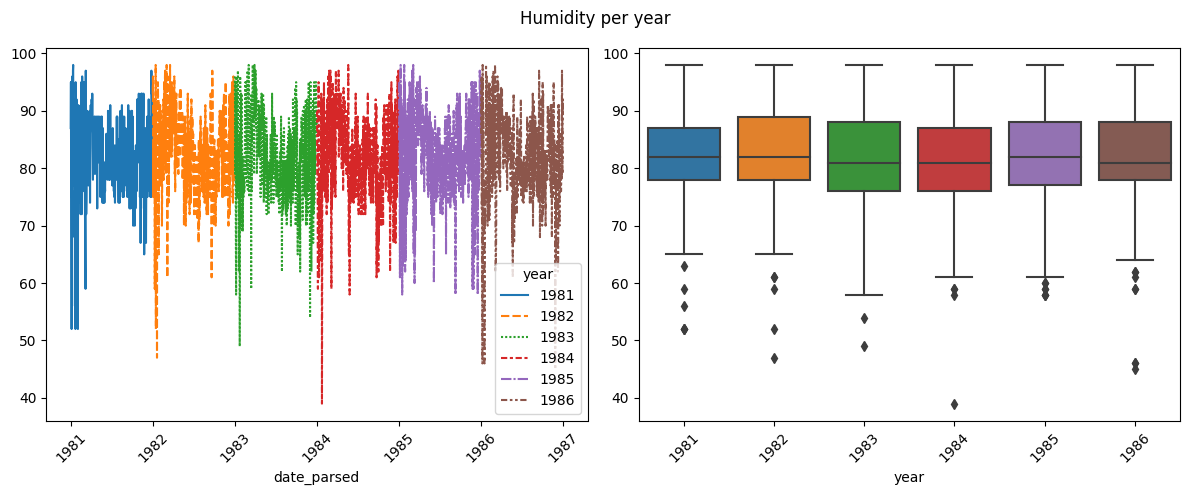

In [37]:
# We graph the humidity per year

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.lineplot(data=year_humidity, ax=axes[0]).tick_params(axis='x', labelrotation=45)
sns.boxplot(data=year_humidity, ax=axes[1]).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Humidity per year")
plt.tight_layout()
plt.show()

We didn't find any significant differences or patterns in these years that would define a significant contribution to the rainfall present in each year. We found significant variation from year to year, with no marked differences between years with the highest or lowest rainfall. There were also atypical values present in all years.

In [38]:
year_temparature = rainfall_new.pivot(index="date_parsed", columns="year", values="temparature")
year_temparature.describe()

year,1981,1982,1983,1984,1985,1986
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,24.129315,23.830685,24.006575,23.978904,23.850411,23.922466
std,4.856760,5.327210,5.230627,5.244942,5.550283,5.129621
min,12.800000,8.300000,8.500000,8.600000,7.400000,8.700000
25%,20.000000,19.300000,19.200000,19.300000,18.700000,20.000000
50%,25.400000,25.400000,25.300000,25.600000,25.800000,25.400000
75%,28.300000,28.200000,28.700000,28.400000,28.400000,28.200000
max,30.800000,31.100000,31.400000,31.500000,31.400000,31.000000


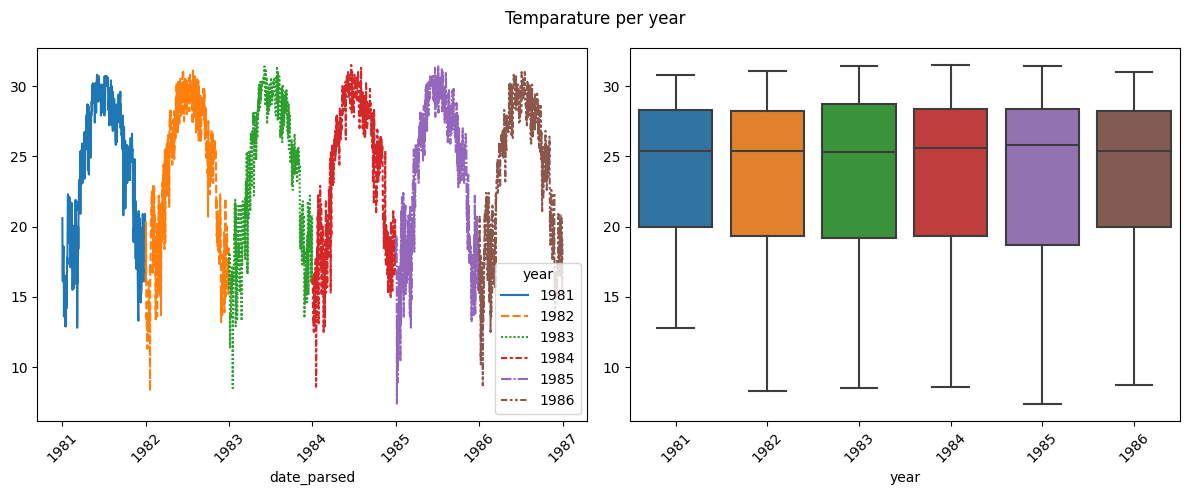

In [39]:
# We graph the pressure per year

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.lineplot(data=year_temparature, ax=axes[0]).tick_params(axis='x', labelrotation=45)
sns.boxplot(data=year_temparature, ax=axes[1]).tick_params(axis='x', labelrotation=45)

plt.suptitle(t="Temparature per year")
plt.tight_layout()
plt.show()

We see an average temperature of 23/24 degrees for all years. We didn't find any outliers. Temperatures in general don't show major differences from what we can see, except for the first year, where the minimum temperature was much higher than the rest.

>- Next we will analyze the trends.

In [40]:
# Moving average with appropriate parameters for trend estimation (12 month)

year_trend = year_rain.rolling(window=12, center=True, min_periods=6).mean()

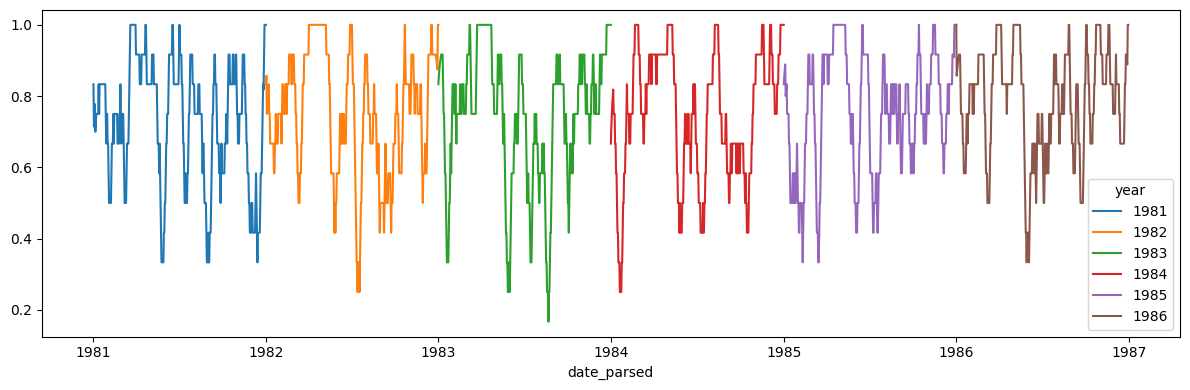

In [41]:
# Moving average chart

fig, axes = plt.subplots(figsize=(12, 4))

sns.lineplot(data=year_trend, dashes=False)

plt.tight_layout()
plt.show()

In [42]:
# Moving average with appropriate parameters for trend estimation (365 days)

average_rain = rainfall_new.groupby("date_parsed").mean()["rainfall"]

rain_trend = average_rain.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

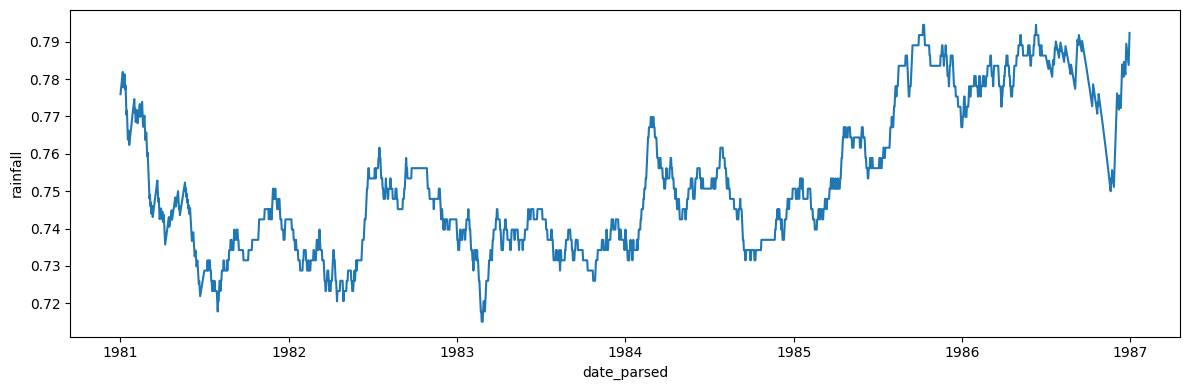

In [43]:
# Moving average chart

fig, axes = plt.subplots(figsize=(12, 4))

sns.lineplot(data=rain_trend, dashes=False)

plt.tight_layout()
plt.show()

We do not see a clear trend for a daily window, monthly may be more appropriate.

# Encoding And Scaling

We didn't find any variables to encode, but we could scale the values.

In [44]:
rainfall_end = rainfall_new.drop(["day", "year", "date_parsed"], axis=1)

In [45]:
rainfall_end.describe().T

,count,mean,std,min,25%,50%,75%,max
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1
winddirection,2190.0,104.863151,80.002416,10.0,40.000,70.00,200.000,300.0
windspeed,2190.0,21.804703,9.898659,4.4,14.125,20.50,27.900,59.5


In [46]:
rainfall_end.corr().style.background_gradient(cmap="Greens")

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
pressure,1.000000,-0.800499,-0.816531,-0.814453,-0.817008,-0.119949,0.098600,-0.257163,-0.643293,0.266012,-0.049886
maxtemp,-0.800499,1.000000,0.982932,0.965529,0.906703,-0.072615,-0.289047,0.452387,0.662235,-0.354168,-0.079304
temparature,-0.816531,0.982932,1.000000,0.987150,0.933617,-0.025016,-0.249355,0.414019,0.668963,-0.342262,-0.049660
mintemp,-0.814453,0.965529,0.987150,1.000000,0.941342,0.009891,-0.219399,0.379497,0.663828,-0.328871,-0.026841
dewpoint,-0.817008,0.906703,0.933617,0.941342,1.000000,0.153390,-0.088446,0.249676,0.643073,-0.312179,0.081965
humidity,-0.119949,-0.072615,-0.025016,0.009891,0.153390,1.000000,0.584854,-0.541592,-0.012430,0.062285,0.454213
cloud,0.098600,-0.289047,-0.249355,-0.219399,-0.088446,0.584854,1.000000,-0.805128,-0.127087,0.184698,0.641191
sunshine,-0.257163,0.452387,0.414019,0.379497,0.249676,-0.541592,-0.805128,1.000000,0.272235,-0.241752,-0.555287
winddirection,-0.643293,0.662235,0.668963,0.663828,0.643073,-0.012430,-0.127087,0.272235,1.000000,-0.192417,-0.006939
windspeed,0.266012,-0.354168,-0.342262,-0.328871,-0.312179,0.062285,0.184698,-0.241752,-0.192417,1.000000,0.111625


We found that it would be convenient, taking into account the different scales of the data, to apply RobustScaler, since there are also some outliers present.

<Axes: >

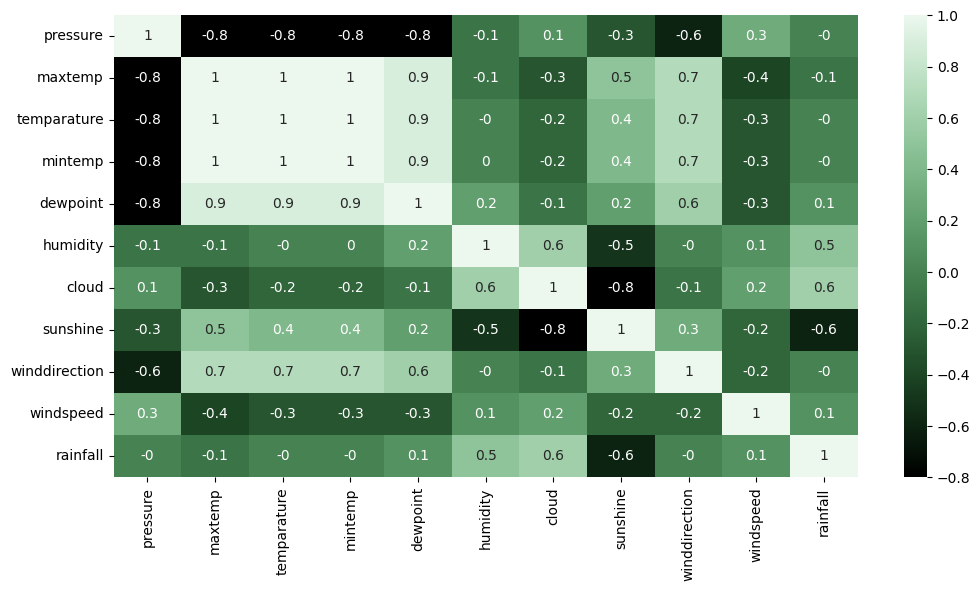

In [47]:
# We graph the correlation between the variables

matrix_rainfall = rainfall_end.corr(numeric_only=True).round(1)

plt.figure(figsize=(12, 6))

sns.heatmap(
    matrix_rainfall, 
    annot=True,
    cmap=sns.cubehelix_palette(
        start=2, rot=0, 
        dark=0, light=.95, 
        reverse=True, as_cmap=True
    )
)

In [48]:
# We separate the target variable from the features

x_rain = rainfall_end.drop(columns="rainfall")
y_rainfall = rainfall_end["rainfall"]

In [49]:
# We transform the data

rs = RobustScaler()

num_va = rs.fit_transform(x_rain)

x_rainfall = pd.DataFrame(
    num_va, columns=rs.get_feature_names_out(x_rain.columns)
)

In [50]:
x_rainfall.describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2.190000e+03,2.190000e+03,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,0.065629,-0.144869,-0.169993,-1.930930e-01,-2.067602e-01,0.003321,-0.383057,0.210067,0.217895,0.094715
std,0.616389,0.571144,0.573891,5.815081e-01,6.449276e-01,0.709150,0.948763,0.566614,0.500015,0.718596
min,-1.525886,-1.757576,-1.989011,-2.281609e+00,-2.737805e+00,-3.909091,-4.263158,-0.375000,-0.375000,-1.168784
25%,-0.479564,-0.656566,-0.681319,-7.068966e-01,-6.524390e-01,-0.454545,-0.736842,-0.312500,-0.187500,-0.462795
50%,0.000000,0.000000,0.000000,-2.046974e-16,2.168404e-16,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.520436,0.343434,0.318681,2.931034e-01,3.475610e-01,0.545455,0.263158,0.687500,0.812500,0.537205
max,2.354223,0.828283,0.659341,6.839080e-01,5.548780e-01,1.454545,0.894737,1.515625,1.437500,2.831216


In [51]:
mi_scores = mutual_info_classif(x_rainfall, y_rainfall)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_rainfall.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

cloud            0.215493
sunshine         0.166479
humidity         0.139446
temparature      0.035376
winddirection    0.019766
mintemp          0.017485
maxtemp          0.014389
dewpoint         0.012121
windspeed        0.011998
pressure         0.010300
Name: MI Scores, dtype: float64

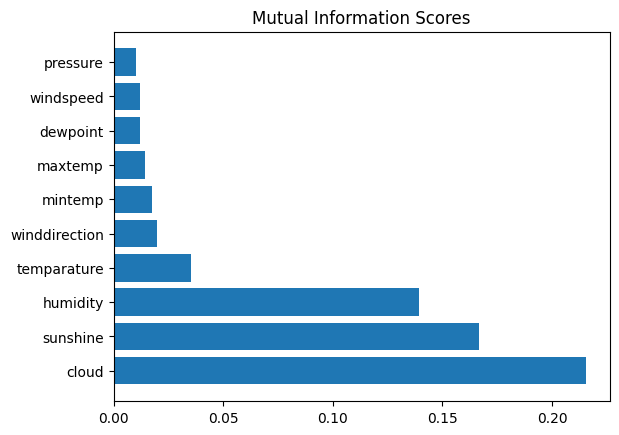

<Figure size 800x500 with 0 Axes>

In [52]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plt.show()

Based on the analysis, correlation and mutual importance, we will reduce the dimension of the dataset, getting rid of some variables.

Note(Version 3): We keep all the variables to see how the models performs with the full data. After the initial results we are reducing dimensionality. All initial results in version 3.

In [53]:
x_rainfall = x_rainfall.drop(columns=["maxtemp", "mintemp", "winddirection"])

In [54]:
x_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pressure     2190 non-null   float64
 1   temparature  2190 non-null   float64
 2   dewpoint     2190 non-null   float64
 3   humidity     2190 non-null   float64
 4   cloud        2190 non-null   float64
 5   sunshine     2190 non-null   float64
 6   windspeed    2190 non-null   float64
dtypes: float64(7)
memory usage: 119.9 KB


# Model Selection

In [55]:
# We separate the data into training and test sets

x_train, x_val, y_train, y_val = (
    train_test_split(
        x_rainfall, y_rainfall, test_size=0.2, random_state=42
    )
)

In [56]:
# We review the balance of the target variable

values_counts = np.asarray(np.unique(y_train, return_counts=True))

print(values_counts)

[[   0    1]
 [ 421 1331]]


In [57]:
def evaluator(model, xtrain, ytrain, xval, yval):

    '''
    We calculate the precision score
    We obtain prediction from the model
    We calculate the f1 score
    Train result and accuracy score test
    Print train and test macro f1 score
    '''

    train_ascore = model.score(xtrain, ytrain)
    val_ascore = model.score(xval, yval)

    y_train_pred = model.predict(xtrain)
    y_val_pred = model.predict(xval)

    train_fscore = f1_score(ytrain, y_train_pred, average="macro")
    val_fscore = f1_score(yval, y_val_pred, average="macro")

    print(f"Train - Accuracy score: {train_ascore}")
    print(f"Test - Accuracy score: {val_ascore}\n")
    print(f"Train - F1-Score: {train_fscore}")
    print(f"Test - F1-Score: {val_fscore}")

In [58]:
def matrix_evaluator(model, xval, yval, list_classes, color_map):
    '''
    We create the confusion matrix
    We plot the confusion matrix
    Report results
    '''
    y_pred = model.predict(xval)
    cm_values = confusion_matrix(yval, y_pred)
    df_cm = pd.DataFrame(
        cm_values,
        columns=list_classes,
        index=list_classes
        )
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=color_map)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")
    print(classification_report(
        yval, y_pred, target_names=list_classes
    ))

## LogisticRegression

In [59]:
# We create the model instance

lrc = LogisticRegression()

# Train the model with the data

lrc.fit(x_train, y_train)

LogisticRegression()

In [60]:
# We make predictions

prediction_lrc = lrc.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, prediction_lrc),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, prediction_lrc)
     )

Confusion matrix:

 [[ 73  46]
 [ 20 299]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.61      0.69       119
           1       0.87      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.78      0.79       438
weighted avg       0.84      0.85      0.84       438



We found an accuracy of 85%, but there is clear confusion for class 0, possibly due to class imbalance. Later we will try to balance the classes, but initially we will use Stratified K-Fold preferred for classification problems with imbalanced datasets.

In [61]:
# We review the parameters

lrc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [62]:
# We establish the parameters to test

lrc_hyperparameters = {
    "C": [0.5, 1.0, 1.5],
    "max_iter": [50, 100, 150],
    "penalty": ["l1","l2","elasticnet","none"]
}

lrc_grid = GridSearchCV(
    lrc,
    lrc_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

lrc_search = lrc_grid.fit(x_train, y_train)

print(
    f"Parametros: {lrc_search.best_params_}\nPuntaje: {lrc_search.best_score_}"
)

Parametros: {'C': 0.5, 'max_iter': 50, 'penalty': 'l2'}
Puntaje: 0.8692942612942612


In [63]:
# We evaluate the accuracy and the f1-score

evaluator(lrc_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.8710045662100456
Test - Accuracy score: 0.8493150684931506

Train - F1-Score: 0.8112094170241091
Test - F1-Score: 0.7933075933075933


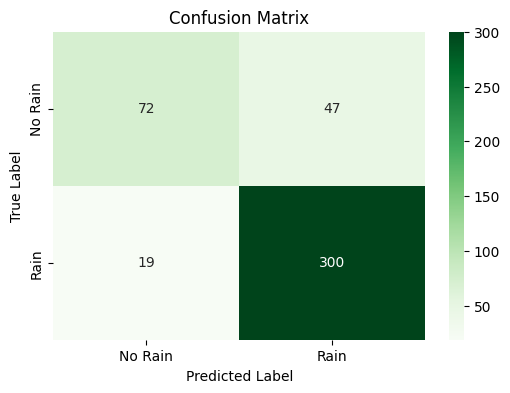



              precision    recall  f1-score   support

     No Rain       0.79      0.61      0.69       119
        Rain       0.86      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.77      0.79       438
weighted avg       0.84      0.85      0.84       438



In [64]:
# We graph the confusion matrix

matrix_evaluator(
    lrc_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

We found good overall accuracy for both classes, but analyzing recall reveals a persistent confusion for class 0. In the F1 score, we see that, on average, the model handles class 1 very well, but class 0 only poorly.

## LabelPropagation

In [65]:
# We create the model instance

label_prop = LabelPropagation()

# Train the model with the data

label_prop.fit(x_train, y_train)

LabelPropagation()

In [66]:
# We make predictions

lp_prediction = label_prop.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, lp_prediction),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, lp_prediction)
     )

Confusion matrix:

 [[ 69  50]
 [ 27 292]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.72      0.58      0.64       119
           1       0.85      0.92      0.88       319

    accuracy                           0.82       438
   macro avg       0.79      0.75      0.76       438
weighted avg       0.82      0.82      0.82       438



We observed lower performance and greater confusion for class 0. We will try a parameter grid to try to improve the result.

In [67]:
label_prop.get_params()

{'gamma': 20,
 'kernel': 'rbf',
 'max_iter': 1000,
 'n_jobs': None,
 'n_neighbors': 7,
 'tol': 0.001}

In [68]:
# We establish the parameters to test

lp_hyperparameters = {
    "gamma": [10, 20, 30],
    "kernel" : ["knn", "rbf"],
    "max_iter": [500, 1000, 1500],
    "n_neighbors" : [4, 7, 14]
}

lp_grid = GridSearchCV(
    label_prop,
    lp_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

lp_search = lp_grid.fit(x_train, y_train)

print(
    f"Parametros: {lp_search.best_params_}\nPuntaje: {lp_search.best_score_}"
)

Parametros: {'gamma': 10, 'kernel': 'knn', 'max_iter': 500, 'n_neighbors': 14}
Puntaje: 0.8641562881562882


In [69]:
# We evaluate the accuracy and the f1-score

evaluator(lp_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.8818493150684932
Test - Accuracy score: 0.8401826484018264

Train - F1-Score: 0.83337123859224
Test - F1-Score: 0.7821948170038646


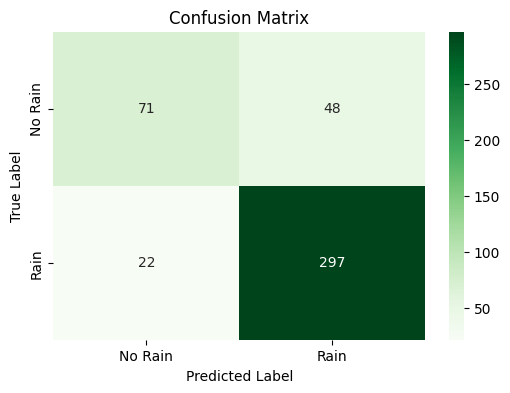



              precision    recall  f1-score   support

     No Rain       0.76      0.60      0.67       119
        Rain       0.86      0.93      0.89       319

    accuracy                           0.84       438
   macro avg       0.81      0.76      0.78       438
weighted avg       0.83      0.84      0.83       438



In [70]:
# We graph the confusion matrix

matrix_evaluator(
    lp_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

We managed to improve the overall accuracy of the model. Regarding confusion for class 0, despite the model's improvement in detecting this class, the confusion persists.

## XGBClassifier

In [71]:
# We create the model instance

xgbc = xgb.XGBClassifier()

# Train the model with the data

xgbc.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
# We make predictions

xgbc_prediction = xgbc.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, xgbc_prediction),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, xgbc_prediction)
     )

Confusion matrix:

 [[ 68  51]
 [ 22 297]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.57      0.65       119
           1       0.85      0.93      0.89       319

    accuracy                           0.83       438
   macro avg       0.80      0.75      0.77       438
weighted avg       0.83      0.83      0.83       438



The overall accuracy is good, but like the other models we found that it doesn't handle class 0 very well.

In [73]:
xgbc.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [74]:
# We establish the parameters to test

xgbc_hyperparameters = {
    "n_estimators": [100, 150],
    "max_depth" : [6, 8],
    "gamma" : [0, 1],
    "alpha" : [0, 1],
    "subsample" : [0.5, 1],
    "scale_pos_weight" : [1, 2]
}

xgbc_grid = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search = xgbc_grid.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search.best_params_}\nPuntaje: {xgbc_search.best_score_}"
)

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
Puntaje: 0.8670150590150592


In [75]:
# We evaluate the accuracy and the f1-score

evaluator(xgbc_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9286529680365296
Test - Accuracy score: 0.860730593607306

Train - F1-Score: 0.899553033934104
Test - F1-Score: 0.8119973261091369


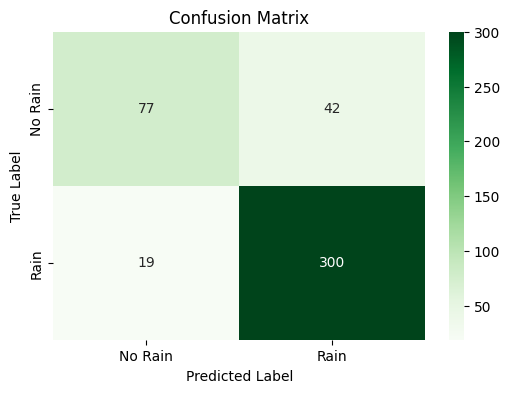



              precision    recall  f1-score   support

     No Rain       0.80      0.65      0.72       119
        Rain       0.88      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.79      0.81       438
weighted avg       0.86      0.86      0.86       438



In [76]:
# We graph the confusion matrix

matrix_evaluator(
    xgbc_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

With an initial hyperparameter test, we were able to improve the overall performance of the model, as well as its ability to detect both classes. We still find a confusion for class 0.

We will evaluate the final result of all models to make the selection and continue optimizing said model.

In [77]:
# We obtain the accuracy score of the models

y_val_pred_lrc = lrc_search.predict(x_val)
y_val_pred_lp = lp_search.predict(x_val)
y_val_pred_xgbc = xgbc_search.predict(x_val)

lr_model = accuracy_score(y_val, y_val_pred_lrc)
lp_model = accuracy_score(y_val, y_val_pred_lp)
xgbc_model = accuracy_score(y_val, y_val_pred_xgbc)

# We compare the accuracy of the models

print(
    "LogisticRegression accuracy score: {0:0.3f}\n".format(lr_model),
    "\nLabelPropagation accuracy score: {0:0.3f}\n".format(lp_model),
    "\nXGBClassifier accuracy score: {0:0.3f}\n".format(xgbc_model)
)

LogisticRegression accuracy score: 0.849
 
LabelPropagation accuracy score: 0.840
 
XGBClassifier accuracy score: 0.861



In [78]:
# We are left with the probabilities of the positive class (the probability of 1)

lrc_probs = lrc_search.predict_proba(x_train)
lrc_probs = lrc_probs[:, 1]
lpc_probs = lp_search.predict_proba(x_train)
lpc_probs = lpc_probs[:, 1]
xgbc_probs = xgbc_search.predict_proba(x_train)
xgbc_probs = xgbc_probs[:, 1]

# We generate an untrained classifier, which will assign 0 to everything

ns_probs = [0 for _ in range(len(y_train))]

# We calculate the AUC

ns_auc = roc_auc_score(y_train, ns_probs)
lrc_auc = roc_auc_score(y_train, lrc_probs)
lpc_auc = roc_auc_score(y_train, lpc_probs)
xgbc_auc = roc_auc_score(y_train, xgbc_probs)

# We print on screen

print('\nUntrained model: ROC AUC = %.3f' % (ns_auc))
print('\nLogisticRegression: ROC AUC = %.3f' % (lrc_auc))
print('\nLabelPropagation: ROC AUC = %.3f' % (lpc_auc))
print('\nXGBClassifier: ROC AUC = %.3f' % (xgbc_auc))


Untrained model: ROC AUC = 0.500

LogisticRegression: ROC AUC = 0.903

LabelPropagation: ROC AUC = 0.924

XGBClassifier: ROC AUC = 0.969


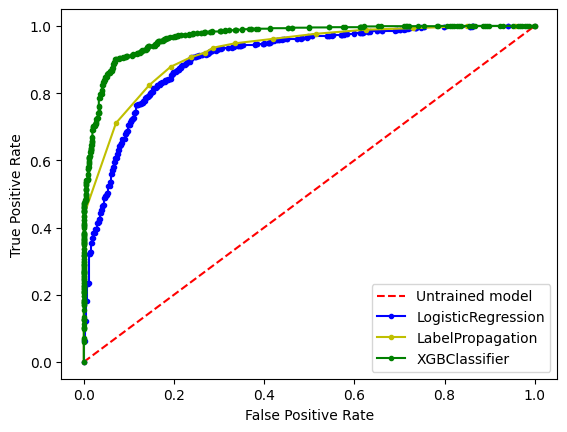

In [79]:
# We calculate the ROC curves

ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lrc_fpr, lrc_tpr, _ = roc_curve(y_train, lrc_probs)
lpc_fpr, lpc_tpr, _ = roc_curve(y_train, lpc_probs)
xgbc_fpr, xgbc_tpr, _ = roc_curve(y_train, xgbc_probs)

# We plot the ROC curve

plt.plot(
    ns_fpr, ns_tpr, linestyle="--", color="r", label="Untrained model"
)
plt.plot(
    lrc_fpr, lrc_tpr, marker=".", color="b", label="LogisticRegression"
)
plt.plot(
    lpc_fpr, lpc_tpr, marker=".", color="y", label="LabelPropagation"
)
plt.plot(
    xgbc_fpr, xgbc_tpr, marker=".", color="g", label="XGBClassifier"
)

# We customize the graph

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

We found similar overall performance across the models. We will initially continue with XGBC to obtain a first result and submit.

# Modeling

We will try a different approach to improve the initial results and a different cross-validation method such as StratifiedKFold.

In [80]:
# We tested a new grid with cv=10

xgbc_grid_two = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=10,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search_two = xgbc_grid_two.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search_two.best_params_}\nPuntaje: {xgbc_search_two.best_score_}"
)

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
Puntaje: 0.8664512987012987


In [81]:
# We make predictions

xgbc_prediction_two = xgbc_search_two.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, xgbc_prediction_two),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, xgbc_prediction_two)
     )

Confusion matrix:

 [[ 77  42]
 [ 19 300]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.65      0.72       119
           1       0.88      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.79      0.81       438
weighted avg       0.86      0.86      0.86       438



### StratifiedKFold object with 5 divisions (k=5):

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
  
Puntaje: 0.8635816035816036

Train - Accuracy score: 0.9246575342465754 / Test - Accuracy score: 0.8493150684931506

Train - F1-Score: 0.8934660033167496 / Test - F1-Score: 0.7972222222222223

Confusion matrix:

 [[ 75  44]
 
 [ 22 297]] 

Classification Report:

                   precision    recall  f1-score   support

               0       0.77      0.63      0.69       119
               1       0.87      0.93      0.90       319

        accuracy                           0.85       438
       macro avg       0.82      0.78      0.80       438
    weighted avg       0.84      0.85      0.84       438


### StratifiedKFold object with 10 divisions (k=10):

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}

Puntaje: 0.8693149350649352

Train - Accuracy score: 0.9246575342465754 / Test - Accuracy score: 0.8493150684931506

Train - F1-Score: 0.8934660033167496 / Test - F1-Score: 0.7972222222222223

Confusion matrix:

 [[ 75  44]
 
 [ 22 297]] 

Classification Report:

                   precision    recall  f1-score   support

               0       0.77      0.63      0.69       119
               1       0.87      0.93      0.90       319

        accuracy                           0.85       438
       macro avg       0.82      0.78      0.80       438
    weighted avg       0.84      0.85      0.84       438

We didn't observe any major changes in the results overall. We'll try a different cross-validation method.

In [82]:
# Create the StratifiedKFold object with 10 divisions (k=10)

s_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Hyperparameters tested:

    xgbc_hyperparameters = {

      "n_estimators": [100, 150, 200, 250, 300],
      "max_depth" : [3, 4, 6, 8, 10],
      "gamma" : [0, 1, 2, 3, 4, 5],
      "min_child_weight" : [0, 1, 2, 3, 4],
      "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
      "scale_pos_weight" : [0, 1, 2, 3, 4, 5]
    }

In [83]:
# We tested a new grid with StratifiedKFold

# We establish the parameters to test

xgbc_hyperparameters = {
    "n_estimators": [250],
    "gamma" : [4],
    "max_depth" : [3],
    "min_child_weight" : [4],
    "subsample" : [0.6],
    "scale_pos_weight" : [2]
}

xgbc_grid_skf = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=s_kfold,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search_skf = xgbc_grid_skf.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search_skf.best_params_}\nPuntaje: {xgbc_search_skf.best_score_}"
)

Parametros: {'gamma': 4, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 250, 'scale_pos_weight': 2, 'subsample': 0.6}
Puntaje: 0.8550357142857143


In [84]:
# We make predictions

xgbc_prediction_skf = xgbc_search_skf.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, xgbc_prediction_skf),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, xgbc_prediction_skf)
     )

Confusion matrix:

 [[ 63  56]
 [ 15 304]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.53      0.64       119
           1       0.84      0.95      0.90       319

    accuracy                           0.84       438
   macro avg       0.83      0.74      0.77       438
weighted avg       0.83      0.84      0.83       438



After analyzing the first approaches, we will train with the best estimator.

In [85]:
# We fit the best estimator

xgbc_result = xgbc_search_skf.best_estimator_  
xgbc_result.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
# We evaluate the accuracy and the f1-score

evaluator(xgbc_result, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9143835616438356
Test - Accuracy score: 0.8378995433789954

Train - F1-Score: 0.868350392343884
Test - F1-Score: 0.7675141855371067


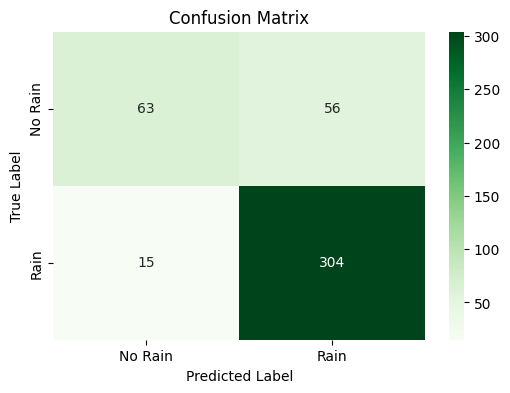



              precision    recall  f1-score   support

     No Rain       0.81      0.53      0.64       119
        Rain       0.84      0.95      0.90       319

    accuracy                           0.84       438
   macro avg       0.83      0.74      0.77       438
weighted avg       0.83      0.84      0.83       438



In [87]:
# We graph the confusion matrix

matrix_evaluator(
    xgbc_result, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

Next we will evaluate the ROC curve and AUC.

In [88]:
# We are left with the probabilities of the positive class (the probability of 1)

xgbc_probs = xgbc_result.predict_proba(x_train)
xgbc_probs = xgbc_probs[:, 1]

# We generate an untrained classifier, which will assign 0 to everything

ns_probs = [0 for _ in range(len(y_train))]

In [89]:
# We calculate the AUC

ns_auc = roc_auc_score(y_train, ns_probs)
xgbc_auc = roc_auc_score(y_train, xgbc_probs)

# We print on screen

print('\nUntrained model: ROC AUC = %.3f' % (ns_auc))
print('\nXGBClassifier: ROC AUC = %.3f' % (xgbc_auc))


Untrained model: ROC AUC = 0.500

XGBClassifier: ROC AUC = 0.957


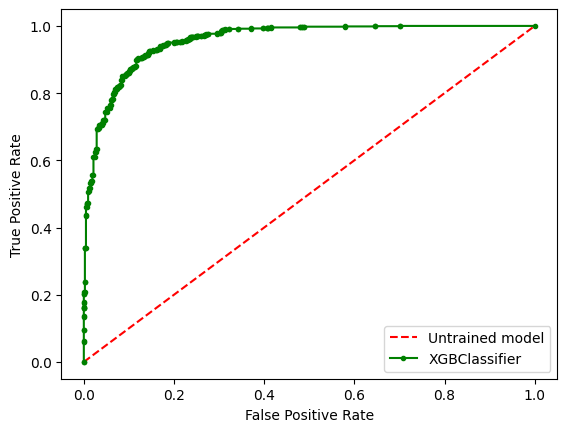

In [90]:
# We calculate the ROC curves

ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
xgbc_fpr, xgbc_tpr, _ = roc_curve(y_train, xgbc_probs)

# We plot the ROC curve

plt.plot(
    ns_fpr, ns_tpr, linestyle="--", color="r", label="Untrained model"
)
plt.plot(
    xgbc_fpr, xgbc_tpr, marker=".", color="g", label="XGBClassifier"
)

# We customize the graph

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

We see a pronounced curve towards the upper left corner, that tells us that the model can achieve a high true positive rate and a low false positive rate. The overall performance of the model, after optimization and obtaining new results, is good. The model still struggles to correctly identify class 0. Class balancing and a broader hyperparameter grid could improve the overall result.

# Test data

We will continue to apply the model to previously unseen values.

In [91]:
# We load the test data

df_test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

In [92]:
# We check the shape and that no duplicate data is found

print(f"Length: {len(df_test.duplicated())}")

print(f"Duplicates: {df_test.duplicated().sum()}")

print(f"Shape: {df_test.shape}")

Length: 730
Duplicates: 0
Shape: (730, 12)


In [93]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [94]:
# We start by removing the variables that we will not use

df_test_new = df_test.drop(columns=["id", "day", "maxtemp", "mintemp", "winddirection"])

In [95]:
# We check the null values

null_values_test = (
    pd.DataFrame(
        {f'Amount of Null Data' : df_test_new.isnull().sum(), 
         'Percentage of Null Data' : (
             df_test_new.isnull().sum()) / (len(df_test_new)) * (100)
        }
    ))

null_values_test.style.background_gradient(cmap='Greens')

,Amount of Null Data,Percentage of Null Data
pressure,0,0.000000
temparature,0,0.000000
dewpoint,0,0.000000
humidity,0,0.000000
cloud,0,0.000000
sunshine,0,0.000000
windspeed,0,0.000000


In [96]:
# We transform the data

num_va_test = rs.fit_transform(df_test_new)

rainfall_test = pd.DataFrame(
    num_va_test, columns=rs.get_feature_names_out(df_test_new.columns)
)

In [97]:
rainfall_test.describe()

,pressure,temparature,dewpoint,humidity,cloud,sunshine,windspeed
count,730.000000,7.300000e+02,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.090480,-1.972763e-01,-0.224374,0.057010,-0.349459,0.230612,0.085198
std,0.620380,6.173214e-01,0.657460,0.665422,0.943901,0.573114,0.716171
min,-1.430986,-2.309942e+00,-2.719512,-3.659574,-4.368421,-0.346457,-1.208633
25%,-0.447887,-6.812865e-01,-0.670732,-0.404255,-0.736842,-0.295276,-0.489209
50%,0.000000,2.081668e-16,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.552113,3.187135e-01,0.329268,0.595745,0.263158,0.704724,0.510791
max,2.197183,7.192982e-01,0.536585,1.361702,0.894737,1.511811,2.748201


In [98]:
# We apply the trained model

rainfall_predictions = xgbc_result.predict_proba(rainfall_test)

In [99]:
# We review the result

print('Total predictions: ', len(rainfall_predictions), '\n')

Total predictions:  730 



In [100]:
# We obtain the probability of each class

print(rainfall_predictions)

[[0.00166649 0.9983335 ]
 [0.00464511 0.9953549 ]
 [0.03278762 0.9672124 ]
 ...
 [0.00264162 0.9973584 ]
 [0.00758606 0.99241394]
 [0.00975198 0.990248  ]]


In [101]:
# We create the dataframe

rainfall_submission = pd.DataFrame({
    'id' : df_test['id'], 
    'rainfall' : rainfall_predictions[:, 1]
})

rainfall_submission.head(10)

,id,rainfall
0,2190,0.998334
1,2191,0.995355
2,2192,0.967212
3,2193,0.354371
4,2194,0.047262
5,2195,0.862235
6,2196,0.982495
7,2197,0.991298
8,2198,0.991161
9,2199,0.944571


In [102]:
# We load the submission sample data

rainfall_sample = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

In [103]:
# We compare the results with the sample

print(
    f"Shape Sample Submission: {rainfall_sample.shape}",
    f"\nShape Rainfall Submission: {rainfall_submission.shape}"
)
print("\n", rainfall_sample.head())

Shape Sample Submission: (730, 2) 
Shape Rainfall Submission: (730, 2)

      id  rainfall
0  2190         0
1  2191         0
2  2192         0
3  2193         0
4  2194         0


In [104]:
# We convert the dataframe to a csv file

rainfall_submission.to_csv("submission.csv", index=False)